In [204]:
import csv
import random
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn import impute
from sklearn import feature_selection
from sklearn import tree
from sklearn import neural_network
from sklearn import cluster
from sklearn import metrics
from copy import deepcopy

warnings.filterwarnings('ignore')

def loadFile(filePath):
    dataset = []
    with open(filePath, 'r') as fd:
        header = next(fd)
        reader = csv.reader(fd, delimiter=';')
        for row in reader:
            for i in range(len(row)):
                row[i] = float(row[i])
            dataset.append(row)
    return dataset, header.replace('"', '').split(';')

def createDataFrame(dataset, header, classification=None):
    df = pd.DataFrame(dataset, columns = header)
    if classification is None:
        df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]
        df = df.drop("quality", axis=1)
        X = df.drop("wine classification", axis=1)
    else:
        df["wine classification"] = classification
        X = df.drop("wine classification", axis=1)
    return df, X

def removeValues(dataset, percentage):
    copy = deepcopy(dataset)
    toRemove = int(len(dataset[0])*percentage)
    for row in copy:
        for i in range(toRemove):
            feature = int(random.random() * len(row)) 
            row[feature] = np.nan
    return copy

def handleMissingValues(dataset, strat):
    imp = sk.impute.SimpleImputer(missing_values=np.nan, strategy=strat)
    return imp.fit_transform(dataset)

def applyNormalization(dataset, norm):
    copy = deepcopy(dataset)
    return sk.preprocessing.normalize(copy, norm=norm)

def applyDiscretization(dataset):
    copy = deepcopy(dataset)
    transf = sk.preprocessing.KBinsDiscretizer(n_bins = 10, encode = 'ordinal', strategy = 'quantile')
    return transf.fit_transform(copy)

def applyDataReduction(dataset):
    copy = deepcopy(dataset)
    agglo = sk.cluster.FeatureAgglomeration(n_clusters=5)
    return agglo.fit_transform(copy)

def pearsonCorrelation(dataset, header, target):
    dictPearson = {}
    df = pd.DataFrame(dataset, columns = header)
    y = df[target]          #Target Variable
    X = df.drop(target, axis=1)   #Feature Matrix
    pearson = sk.feature_selection.r_regression(X, y, center=True)
    return pearson

def plotPearson(dataset, header, target, colors):
    pearson = pearsonCorrelation(dataset, header, target)
    headerPearson = deepcopy(header)
    headerPearson.remove(target)
    plt.title('Target Feature: ' + target)
    plt.barh(headerPearson, pearson, height=0.8, align='center', tick_label=headerPearson,
             color=colors)
    plt.xlim([-1,1])
    plt.show()

def plotAllPearson(dataset, header):
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(11)]
    for target in header:
        plotPearson(dataset, header, target, colors)
    
def randomColors(n):
    colors = []
    for i in range(n):
        colors.append(np.random.choice(range(256), size=3))
    print(colors)
    return colors

def correlationMatrix(df, title):
    corr_mat = df.corr()
    plt.figure(figsize=(13,5))
    plt.title(title)
    sns_plot = sns.heatmap(data=corr_mat, annot=True, cmap='GnBu')
    plt.show()
    
def barPlotWineQuality(red, white):
    orderedListRed = []
    orderedListRed.append(red["wine classification"].value_counts()[2])
    orderedListRed.append(red["wine classification"].value_counts()[0])
    orderedListRed.append(red["wine classification"].value_counts()[1])
    
    orderedListWhite = []
    orderedListWhite.append(white["wine classification"].value_counts()[2])
    orderedListWhite.append(white["wine classification"].value_counts()[0])
    orderedListWhite.append(white["wine classification"].value_counts()[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    
    ax1.bar(x=['bad', 'medium', 'good'], height=orderedListRed)
    ax2.bar(x=['bad', 'medium', 'good'], height=orderedListWhite)
    
def visualizePairOfFeatures(df, xfeature, yfeature):
    sns.set(color_codes=True)
    g = sns.lmplot(x=xfeature, y=yfeature, data=df, line_kws={'color': 'limegreen'})
    
def decisionTree(df, X, target, header):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = tree.DecisionTreeClassifier(splitter='best', max_features = 11, random_state = 1)
    clf = clf.fit(X_train, y_train)
    '''
    tree.export_graphviz(clf, out_file='tree.dot', feature_names=header[:-1], class_names=["bad","good","medium"]) 
    plt.figure(figsize=(20, 20))
    tree.plot_tree(clf, feature_names=header, class_names=["bad","good","medium"])
    '''
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
    
def ourMLPClassifier(df, X, target):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = sk.neural_network.MLPClassifier(random_state=1, max_iter=10000).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

def knn(df, X, target):
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=7)
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    knn.fit(X_train, y_train)

    #Predict the response for test dataset
    
    y_pred = knn.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
    
def kMeans(df, X, target, header):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = sk.cluster.KMeans(n_clusters=3, random_state=1).fit(X_train, y_train)
    # caso queiramos ver os resultados, dar return ao predict
    y_pred = clf.predict(X_test)
    silh = metrics.silhouette_score(X, y)
    score = clf.score(X_test)
    return silh, score

def dbscanOptimalEps(X):
    neigh = sk.neighbors.NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

def dbscan(df, X, target, epsilon, minSamples):
    y = df[target]
    clf = sk.cluster.DBSCAN(eps=epsilon, min_samples=minSamples).fit_predict(X, y)
    # caso queiramos ver os resultados, dar return ao predict
    #clf.predict(X_test)
    clusters = np.unique(clf)[-1]
    bad = [0 for x in range(clusters)]
    medium = [0 for x in range(clusters)]
    good = [0 for x in range(clusters)]
    heatmap = [bad,medium,good]
    
    plt.figure(figsize=(20, 7))
    
    for cluster in range(clusters):
        for index, value in enumerate(clf):
            if value == cluster and y[index] == 'bad':
                bad[cluster] += 1
            elif value == cluster and y[index] == 'medium':
                medium[cluster] += 1
            elif value == cluster and y[index] == 'good':
                good[cluster] += 1
    
    im = plt.imshow(heatmap, cmap="Oranges")
    for i in range(len(heatmap)):
        for j in range(len(heatmap[i])):
            text = plt.text(j, i, heatmap[i][j],
                           ha="center", va="center", color="black")
    plt.show()            
    

def agglomerativeClustering(df, X, target, title):
    y = df[target]
    clusters=3
    clf = sk.cluster.AgglomerativeClustering(n_clusters = clusters).fit_predict(X)
    # caso queiramos ver os resultados, dar return ao predict
    bad = [0,0,0]
    medium = [0,0,0]
    good = [0,0,0]
    heatmap = [bad,medium,good]
    
    for cluster in range(clusters):
        for index, value in enumerate(clf):
            if value == cluster and y[index] == 'bad':
                bad[cluster] += 1
            elif value == cluster and y[index] == 'medium':
                medium[cluster] += 1
            elif value == cluster and y[index] == 'good':
                good[cluster] += 1
    
    fig, ax = plt.subplots()
    im = ax.imshow(heatmap, cmap="Oranges")
    
    for i in range(len(heatmap)):
        for j in range(len(heatmap[i])):
            text = ax.text(j, i, heatmap[i][j],
                           ha="center", va="center", color="black")
            
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(['0','1','2'])
    ax.set_yticks([0,1,2])
    ax.set_yticklabels(['bad','medium','good'])
    plt.title(title)
    plt.show()

# Data Loading

## Load Datasets

Efetuámos o carregamento dos dados de ambos os datasets para duas listas. A primeira, denominada de `redWineData` e `whiteWineData`, contendo os valores dos atributos que descrevem cada vinho e a segunda contendo o nome de cada um dos atributos.

In [189]:
#Loading Datasets
redWineData, headerRed = loadFile("./winequality-red.csv")
headerRed[11] = headerRed[11].strip('\n')

whiteWineData, headerWhite = loadFile("./winequality-white.csv")
headerWhite[11] = headerWhite[11].strip('\n')

## Convert To Dataframe

Recorremos à biblioteca Pandas para converter o dataset num dataframe. Esta estrutura de dados é vantajosa por permitir identificar com maior facilidade a target variable do dataframe, assim como adicionar novos atributos apartir de atributos já existentes. Deste modo, recorremos a uma destas funcionalidades para adicionar o atributo *wine classification*. Este atributo consiste na categorização dos vinhos por *good*, *medium* e *bad*, tendo como base o atributo da qualidade. A classificação foi feita com base nos seguintes critérios:
- Valores de 0 a 4: **bad**
- Valores 5 e 6: **medium**
- Valores de 7 a 10: **good**

In [190]:
redDF, rX = createDataFrame(redWineData, headerRed)

whiteDF, wX = createDataFrame(whiteWineData, headerWhite)

# Data Visualization

Através dos gráficos de barras apresentados, é possível ver a distribuição dos vinhos, de ambos os datasets, pelas 3 categorias criadas anteriormente. Podemos rapidamente perceber que uma grande parte dos vinhos são classificados como *medium*.


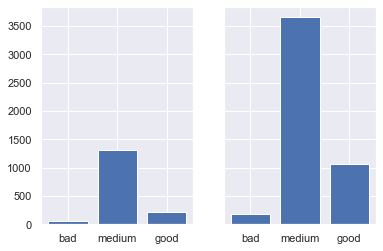

In [191]:
barPlotWineQuality(redDF, whiteDF)

## Data visulization of Red Wine Dataset

### Pairplot

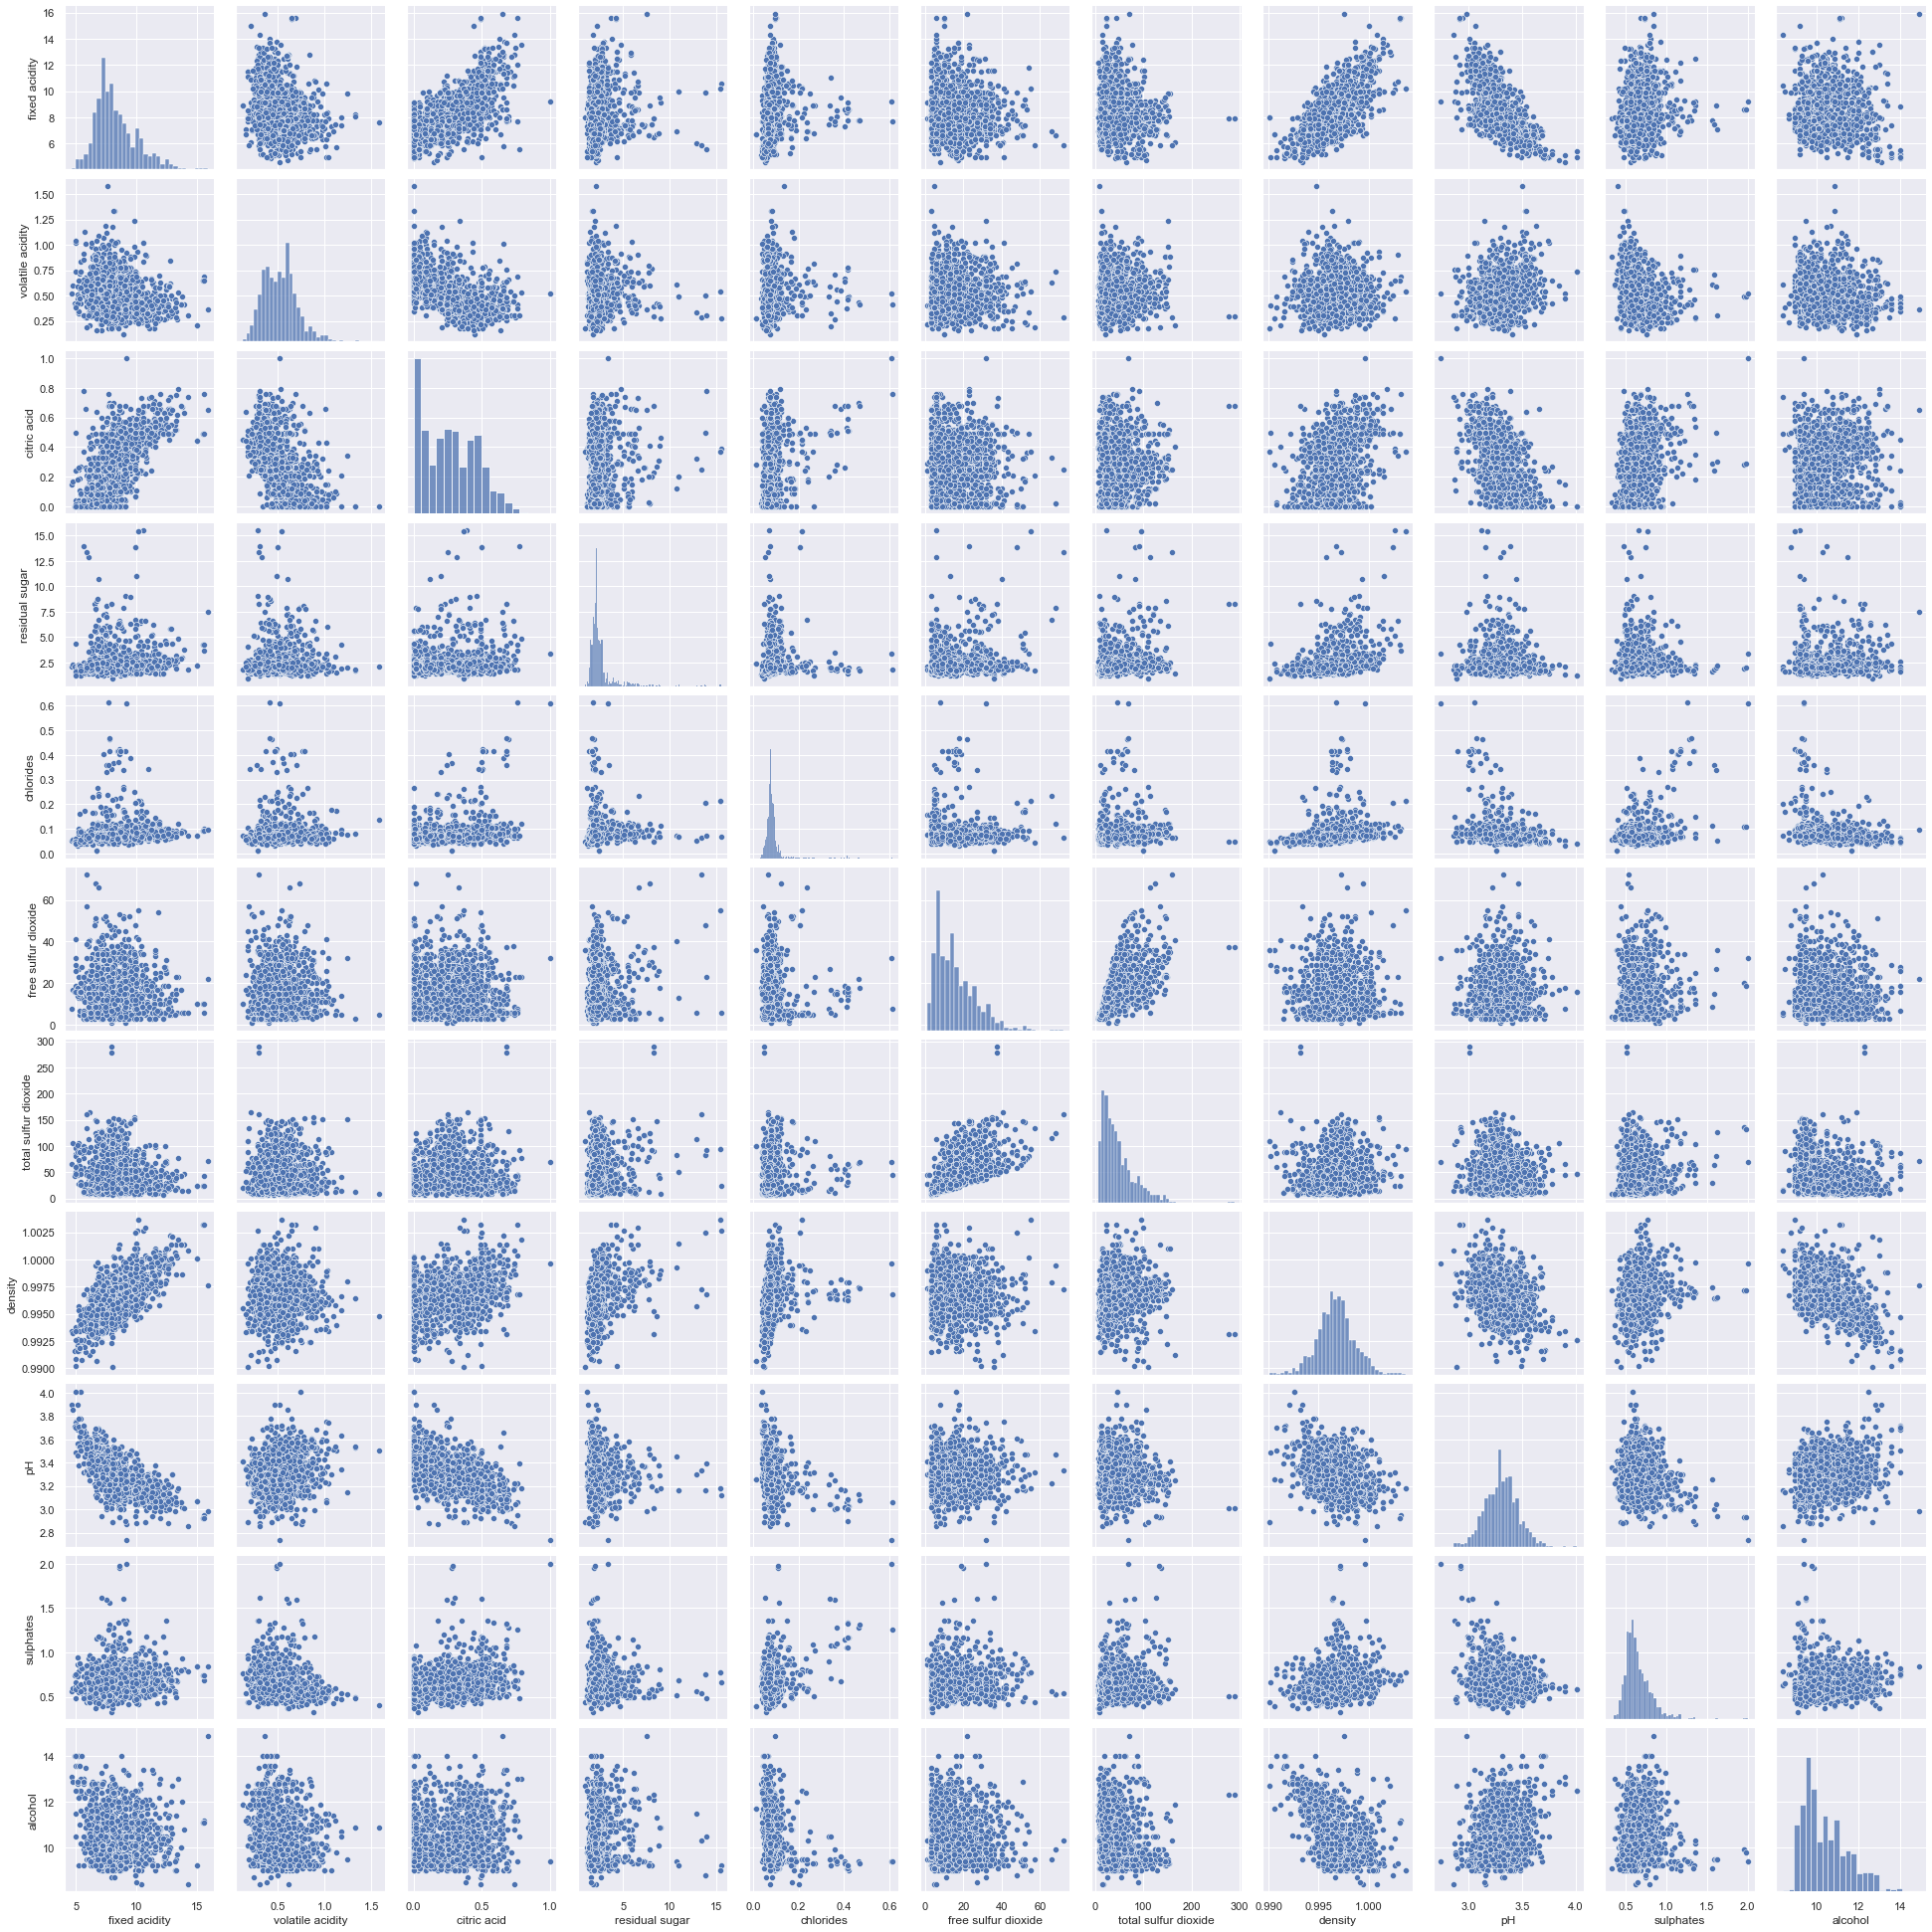

In [82]:
sns_visualization = sns.pairplot(redDF)

### Correlation Matrix

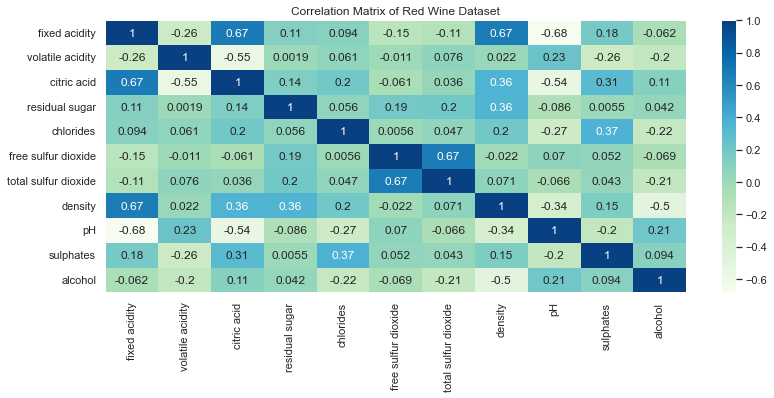

In [83]:
correlationMatrix(redDF, "Correlation Matrix of Red Wine Dataset")

### Correlações a destacar
Após analisar a matriz de confusão e os gráficos do pairplot, ambos apresentados anteriormente, decidimos destacar 4 correlações de atributos, 3 delas positivas e uma negativa.
Nos gráficos a baixo é facilmente identificável que os 3 primeiros têm uma forte correlação positiva pois os valores variam de forma linear, ou seja, os valores do y acompanham o crescimento dos valores do x. No caso do último gráfico, os valores variam de forma linearmente inversa, ou seja, à medida que os valores do x aumentam, os valores do y diminuem.

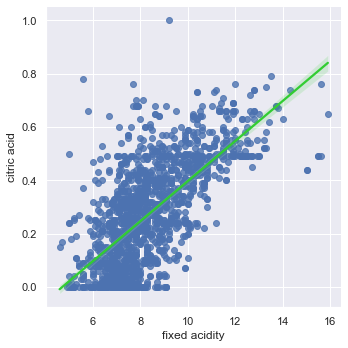

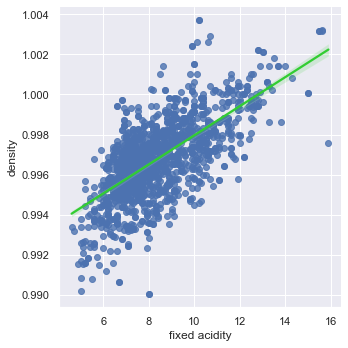

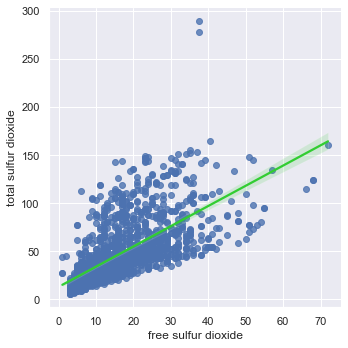

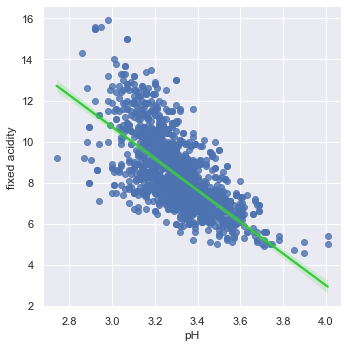

In [84]:
visualizePairOfFeatures(redDF, "fixed acidity", "citric acid")
visualizePairOfFeatures(redDF, "fixed acidity", "density")
visualizePairOfFeatures(redDF, "free sulfur dioxide", "total sulfur dioxide")
visualizePairOfFeatures(redDF, "pH", "fixed acidity")

## Data visualization of White Wine Dataset

### Pairplot

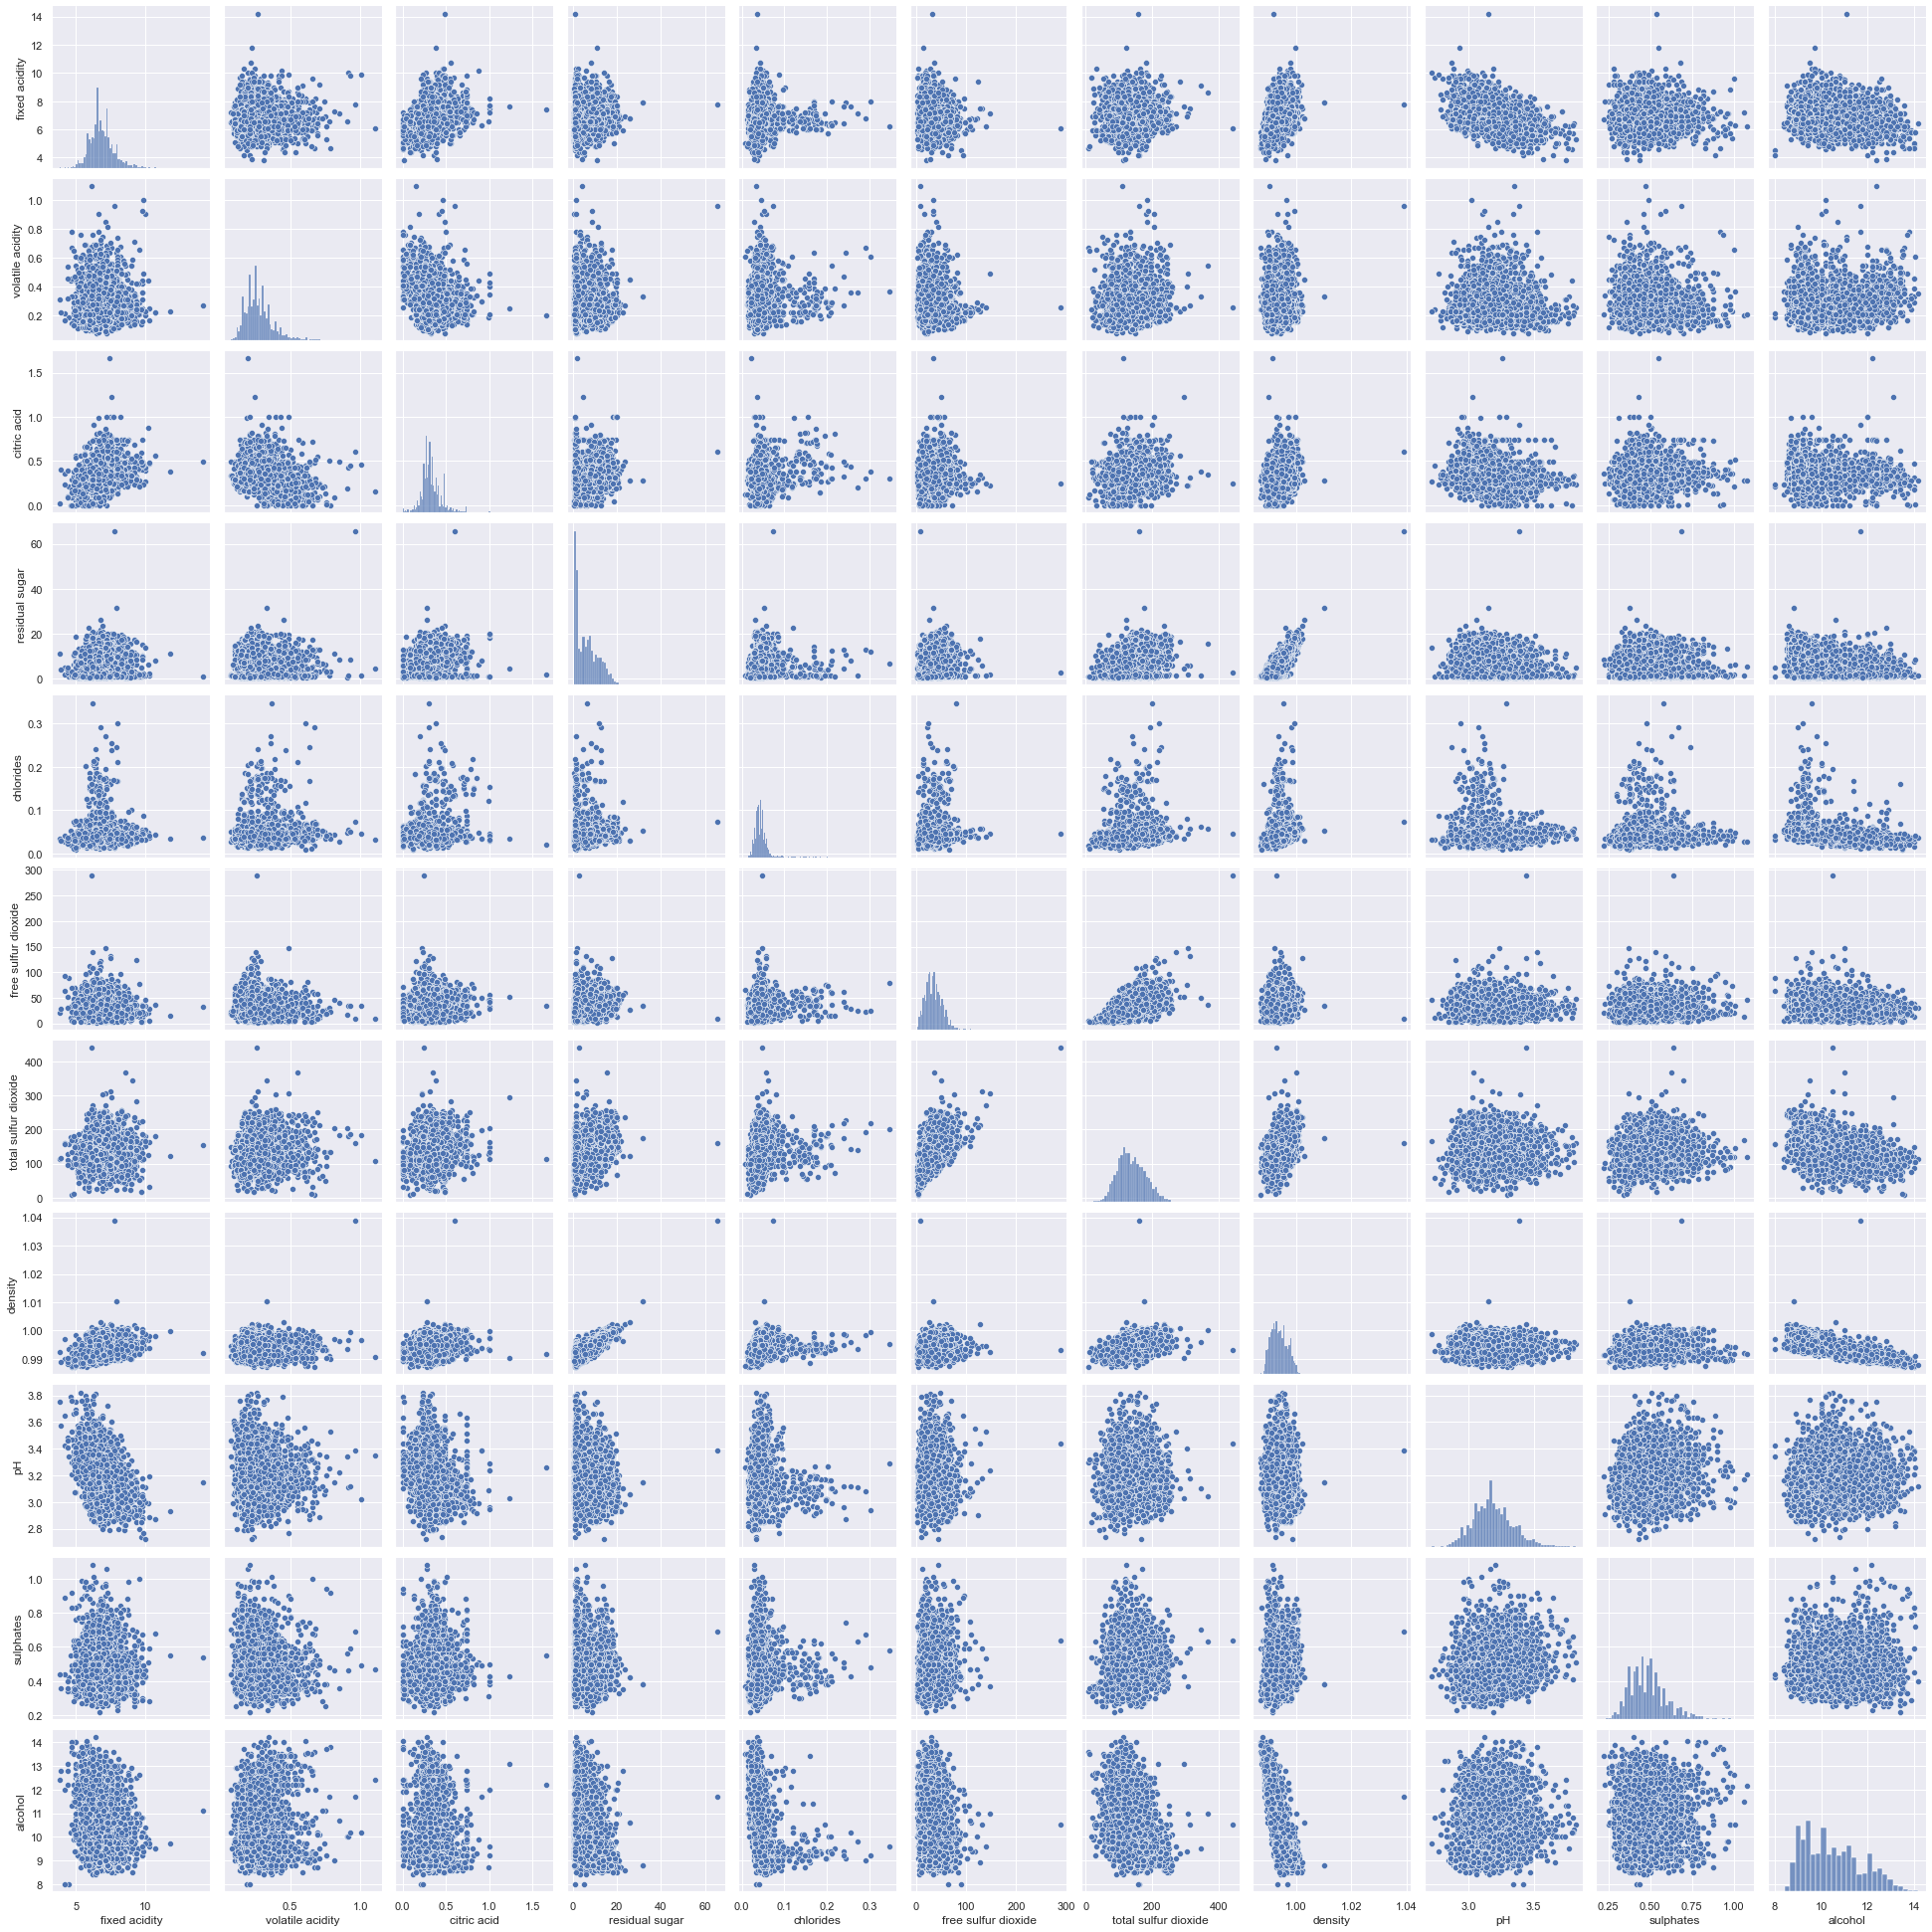

In [85]:
sns_visualization = sns.pairplot(whiteDF)

### Correlation Matrix

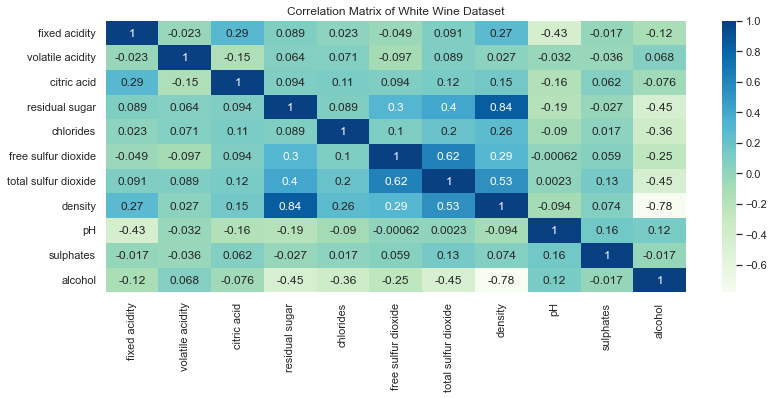

In [86]:
correlationMatrix(whiteDF, "Correlation Matrix of White Wine Dataset")

### Correlações a destacar
Após analisar a matriz de confusão e os gráficos do pairplot, ambos apresentados anteriormente, desta vez em relação ao dataset do vinho branco, decidimos destacar três correlações de atributos, duas delas positivas e uma negativa.
Nos gráficos a baixo é facilmente identificável que os dois primeiros têm uma forte correlação positiva pois os valores variam de forma linear, ou seja, os valores do y acompanham o crescimento dos valores do x. No caso do último gráfico, os valores variam de forma linearmente inversa, ou seja, à medida que os valores do x aumentam, os valores do y diminuem.

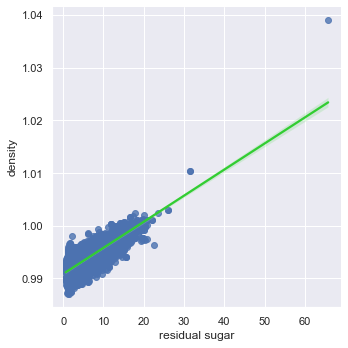

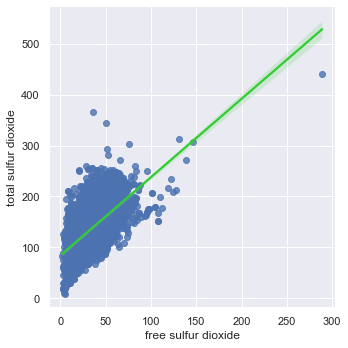

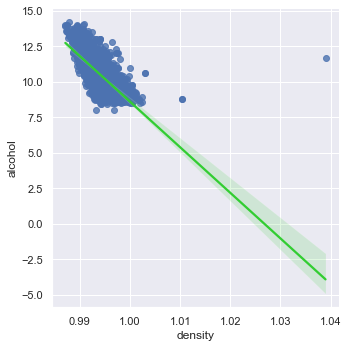

In [87]:
visualizePairOfFeatures(whiteDF, "residual sugar", "density")
visualizePairOfFeatures(whiteDF, "free sulfur dioxide", "total sulfur dioxide")
visualizePairOfFeatures(whiteDF, "density", "alcohol")

# Data Preparation

## Remove Values and Handle Missing Values

De modo a simular o tratamento de *missing values*, removemos aleatoriamente uma determinada percentagem de valores (10%, 20% e 30%) do dataset original. De seguida aplicámos dois metodos de preenchimento dos dados em falta, o *mean* e o *most_frequent*. Os métodos utilizados funcionam da seguinte forma:

- ***mean***: Preenche os dados em falta com a média dos valores do atributo em questão
- ***most_frequent***: Preenche os dados em falta com o valor mais comum do atributo em questão

In [178]:
redMissing10per = removeValues(redWineData, 0.1)
redMissing20per = removeValues(redWineData, 0.2)
redMissing30per = removeValues(redWineData, 0.3)
print("Red Dataset Missing Values Example")
print(redMissing20per[0])

whiteMissing10per = removeValues(whiteWineData, 0.1)
whiteMissing20per = removeValues(whiteWineData, 0.2)
whiteMissing30per = removeValues(whiteWineData, 0.3)
print("\nWhite Dataset Missing Values Example")
print(whiteMissing30per[0])

Red Dataset Missing Values Example
[7.4, nan, 0.0, nan, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4, 5.0]

White Dataset Missing Values Example
[nan, 0.27, 0.36, 20.7, 0.045, nan, nan, 1.001, 3.0, 0.45, 8.8, 6.0]


In [186]:
redMean10 = handleMissingValues(redMissing10per, 'mean')
redMean20 = handleMissingValues(redMissing20per, 'mean')
redMean30 = handleMissingValues(redMissing30per, 'mean')
red10DF, r10X = createDataFrame(redMean10, headerRed)
red20DF, r20X = createDataFrame(redMean20, headerRed)
red30DF, r30X = createDataFrame(redMean30, headerRed)
print("Red Dataset Reducted Example")
print(redMean20[0])

whiteMostFreq10 = handleMissingValues(whiteMissing10per, 'most_frequent')
whiteMostFreq20 = handleMissingValues(whiteMissing20per, 'most_frequent')
whiteMostFreq30 = handleMissingValues(whiteMissing30per, 'most_frequent')
white10DF, w10X = createDataFrame(whiteMostFreq10, headerWhite)
white20DF, w20X = createDataFrame(whiteMostFreq20, headerWhite)
white30DF, w30X = createDataFrame(whiteMostFreq30, headerWhite)
print("\nWhite Dataset Reducted Example")
print(whiteMostFreq30)


Red Dataset Reducted Example
[ 7.4         0.53255805  0.          2.54812594  0.076      11.
 34.          0.9978      3.51        0.56        9.4         5.        ]

White Dataset Reducted Example
[[ 6.8   0.27  0.36 ...  0.45  8.8   6.  ]
 [ 6.8   0.3   0.3  ...  0.49  9.5   6.  ]
 [ 8.1   0.24  0.4  ...  0.44 10.1   6.  ]
 ...
 [ 6.5   0.24  0.19 ...  0.5   9.4   6.  ]
 [ 5.5   0.24  0.3  ...  0.5   9.4   7.  ]
 [ 6.    0.21  0.3  ...  0.32 11.8   6.  ]]


## Normalizing Values

Procedemos agora à normalização dos dados recorrendo a 3 algoritmos diferentes. A normalização tem como objetivo transformar os dados de forma a que estes tenham todos a mesma dimensão e distribuições parecidas. A normalização também ajuda a nivelar a importância de cada variável para que o modelo não seja influenciado pela dimensão dos números.

In [166]:
redNorm1 = applyNormalization(rX, 'l1')
redNorm2 = applyNormalization(rX, 'l2')
redNormMax = applyNormalization(rX, 'max')
redNorm1DF, rNorm1X = createDataFrame(redNorm1, headerRed[:-1], redDF["wine classification"])
redNorm2DF, rNorm2X = createDataFrame(redNorm2, headerRed[:-1], redDF["wine classification"])
redNormMaxDF, rNormMaxX = createDataFrame(redNormMax, headerRed[:-1], redDF["wine classification"])
print("Red Dataset Normalized Example")
print(redNorm1)


whiteNorm1 = applyNormalization(wX, 'l1')
whiteNorm2 = applyNormalization(wX, 'l2')
whiteNormMax = applyNormalization(wX, 'max')
whiteNorm1DF, wNorm1X = createDataFrame(whiteNorm1, headerWhite[:-1], whiteDF["wine classification"])
whiteNorm2DF, wNorm2X = createDataFrame(whiteNorm2, headerWhite[:-1], whiteDF["wine classification"])
whiteNormMaxDF, wNormMaxX = createDataFrame(whiteNormMax, headerWhite[:-1], whiteDF["wine classification"])
print("\nWhite Dataset Normalized Example")
print(whiteNormMax)

Red Dataset Normalized Example
[[0.10640776 0.0100656  0.         ... 0.05047179 0.00805248 0.13516661]
 [0.06607101 0.00745417 0.         ... 0.02710606 0.00576004 0.0830123 ]
 [0.08236623 0.00802543 0.00042239 ... 0.03442486 0.00686385 0.10348578]
 ...
 [0.06667955 0.00539787 0.00137593 ... 0.03619747 0.00793804 0.11642461]
 [0.05887315 0.00643613 0.00119742 ... 0.03562324 0.00708473 0.10178069]
 [0.06937018 0.00358413 0.005434   ... 0.03919415 0.00763072 0.12717867]]

White Dataset Normalized Example
[[0.04117647 0.00158824 0.00211765 ... 0.01764706 0.00264706 0.05176471]
 [0.04772727 0.00227273 0.00257576 ... 0.025      0.00371212 0.0719697 ]
 [0.08350515 0.0028866  0.00412371 ... 0.03360825 0.00453608 0.10412371]
 ...
 [0.05855856 0.00216216 0.00171171 ... 0.02693694 0.00414414 0.08468468]
 [0.05       0.00263636 0.00272727 ... 0.03036364 0.00345455 0.11636364]
 [0.06122449 0.00214286 0.00387755 ... 0.03326531 0.00326531 0.12040816]]


## Data Reduction

Aplicámos também um algoritmo de *data reduction* tendo como objetivo exprimentar se a redução da dimensionalidade do dataset melhora os resultados obtidos. A sua utilização é especialmente interessante quando existem atributos com uma alta correlação entre si e quando existe um elevado número de atributos.

In [163]:
redReduct = applyDataReduction(rX)
print("Red Dataset Reducted Example")
print(redReduct)

whiteReduct = applyDataReduction(wX)
print("\nWhite Dataset Reducted Example")
print(whiteReduct)

Red Dataset Reducted Example
[[ 8.4       0.46676   2.705    11.       34.      ]
 [ 8.8       0.53096   2.9      25.       67.      ]
 [ 8.8       0.5078    2.78     15.       54.      ]
 ...
 [ 8.65      0.492348  2.86     29.       40.      ]
 [ 8.05      0.509094  2.785    32.       44.      ]
 [ 8.5       0.500498  3.495    18.       42.      ]]

White Dataset Reducted Example
[[  7.9          0.85433333  45.         170.          20.7       ]
 [  7.9          0.91216667  14.         132.           1.6       ]
 [  9.1          0.90418333  30.          97.           6.9       ]
 ...
 [  7.95         0.81892333  30.         111.           1.2       ]
 [  9.15         0.88678167  20.         110.           1.1       ]
 [  8.9          0.863235    22.          98.           0.8       ]]


## Data Discretization


A discretização serve para agrupar de forma categorica valores que são contínuos. Como podemos observar através do exemplos os valores dos atributos que eram originalmente contínuos passam a estar definidos entre valores de 0 a 9 (o número total de *bins* escolhido).

In [162]:
redDiscret = applyDiscretization(rX)
redDiscretDF, redDiscretX = createDataFrame(redDiscret, headerRed[:-1], redDF["wine classification"])
print("Red Dataset Discretized Example")
print(redDiscret)

whiteDiscret = applyDiscretization(wX)
whiteDiscretDF, whiteDiscretX = createDataFrame(whiteDiscret, headerWhite[:-1], whiteDF["wine classification"])
print("\nWhite Dataset Discretized Example")
print(whiteDiscret)

Red Dataset Discretized Example
[[3. 8. 0. ... 9. 2. 1.]
 [4. 9. 0. ... 2. 6. 3.]
 [4. 9. 1. ... 3. 6. 3.]
 ...
 [0. 4. 3. ... 7. 7. 7.]
 [0. 7. 2. ... 9. 7. 5.]
 [0. 1. 8. ... 7. 6. 7.]]

White Dataset Discretized Example
[[6. 5. 6. ... 1. 4. 0.]
 [2. 6. 6. ... 7. 5. 2.]
 [9. 6. 7. ... 7. 3. 4.]
 ...
 [3. 4. 0. ... 0. 4. 2.]
 [0. 6. 4. ... 8. 1. 9.]
 [1. 2. 7. ... 7. 0. 8.]]


# Modeling

## Supervised Learning Algorithms

### Decision Tree Algorithm

In [195]:
print("(Accuracy, Precision, Recall, F1)")

print("\nScore results for Red Dataset")
print(decisionTree(redDF, rX, "wine classification", headerRed))
print(decisionTree(red20DF, r20X, "wine classification", headerRed))
print(decisionTree(redNorm1DF, rNorm1X, "wine classification", headerRed))
print(decisionTree(redDiscretDF, redDiscretX, "wine classification", headerRed))

print("\nScore results for White Dataset")
print(decisionTree(whiteDF, wX, "wine classification", headerWhite))
print(decisionTree(white20DF, w20X, "wine classification", headerWhite))
print(decisionTree(whiteNorm1DF, wNorm1X, "wine classification", headerWhite))
print(decisionTree(whiteDiscretDF, whiteDiscretX, "wine classification", headerWhite))

(Accuracy, Precision, Recall, F1)

Score results for Red Dataset
(0.8125, 0.8062270510613884, 0.8125, 0.8092729626868601)
(0.79, 0.7946617647058823, 0.79, 0.7918429072508768)
(0.86, 0.84997122775184, 0.86, 0.8537137430162925)
(0.8325, 0.8239557008307008, 0.8325, 0.8280806100217865)

Score results for White Dataset
(0.7551020408163265, 0.7669586476386083, 0.7551020408163265, 0.7602444506943669)
(0.7028571428571428, 0.7138513913279715, 0.7028571428571428, 0.7081162384631113)
(0.7779591836734694, 0.7732579225238483, 0.7779591836734694, 0.7754587170239984)
(0.763265306122449, 0.7654237298254097, 0.763265306122449, 0.7642802079404101)


### Multi-Layer Perceptron Algorithm

In [205]:
print("(Accuracy, Precision, Recall, F1)")

print("\nScore results for Red Dataset")
print(ourMLPClassifier(redDF, rX, "wine classification"))
print(ourMLPClassifier(red20DF, r20X, "wine classification"))
print(ourMLPClassifier(redNorm1DF, rNorm1X, "wine classification"))
print(ourMLPClassifier(redDiscretDF, redDiscretX, "wine classification"))

print("\nScore results for White Dataset")
print(ourMLPClassifier(whiteDF, wX, "wine classification"))
print(ourMLPClassifier(white20DF, w20X, "wine classification"))
print(ourMLPClassifier(whiteNorm1DF, wNorm1X, "wine classification"))
print(ourMLPClassifier(whiteDiscretDF, whiteDiscretX, "wine classification"))

(Accuracy, Precision, Recall, F1)

Score results for Red Dataset
(0.84, 0.7922823529411765, 0.84, 0.8046835443037975)
(0.86, 0.8100654450261779, 0.86, 0.8245816890292026)
(0.83, 0.7750657894736841, 0.83, 0.786670846999807)
(0.855, 0.8381801242236024, 0.855, 0.8409323529411763)

Score results for White Dataset
(0.7387755102040816, 0.6957454253188543, 0.7387755102040816, 0.7027347401920729)
(0.7844897959183673, 0.6487711680416847, 0.7844897959183673, 0.6919708454810496)
(0.7444897959183674, 0.7100363316558181, 0.7444897959183674, 0.6812157167627838)
(0.7926530612244898, 0.7791421691751527, 0.7926530612244898, 0.7829145704342537)


### k-NN Algorithm

In [206]:
print("(Accuracy, Precision, Recall, F1)")

print("\nScore results for Red Dataset")
print(knn(redDF, rX, "wine classification"))
print(knn(red20DF, r20X, "wine classification"))
print(knn(redNorm1DF, rNorm1X, "wine classification"))
print(knn(redDiscretDF, redDiscretX, "wine classification"))

print("\nScore results for White Dataset")
print(knn(whiteDF, wX, "wine classification"))
print(knn(white20DF, w20X, "wine classification"))
print(knn(whiteNorm1DF, wNorm1X, "wine classification"))
print(knn(whiteDiscretDF, whiteDiscretX, "wine classification"))


(Accuracy, Precision, Recall, F1)

Score results for Red Dataset
(0.8175, 0.7670325203252033, 0.8175, 0.7845350500715307)
(0.8675, 0.826921009581678, 0.8675, 0.8251524330662496)
(0.815, 0.7542529411764706, 0.815, 0.7758761867088608)
(0.8275, 0.7799648412529298, 0.8275, 0.800683908314271)

Score results for White Dataset
(0.7453061224489796, 0.700737774355025, 0.7453061224489796, 0.7120271536250694)
(0.7583673469387755, 0.6774866639432099, 0.7583673469387755, 0.701263844131311)
(0.7281632653061224, 0.6887423562954299, 0.7281632653061224, 0.7015988197483323)
(0.7877551020408163, 0.7563722885520218, 0.7877551020408163, 0.7670351852562096)


## Unsupervised Learning Algorithms

### k-Means Algorithm

In [200]:
print("(Silhoute, Score)")

print("\nScore results for Red Dataset")
print(kMeans(redDF, rX, "wine classification", headerRed))
print(kMeans(red20DF, r20X, "wine classification", headerRed))
print(kMeans(redNorm1DF, rNorm1X, "wine classification", headerRed))
print(kMeans(redDiscretDF, redDiscretX, "wine classification", headerRed))

print("\nScore results for White Dataset")
print(kMeans(whiteDF, wX, "wine classification", headerRed))
print(kMeans(white20DF, w20X, "wine classification", headerRed))
print(kMeans(whiteNorm1DF, wNorm1X, "wine classification", headerRed))
print(kMeans(whiteDiscretDF, whiteDiscretX, "wine classification", headerRed))


(Silhoute, Score)

Score results for Red Dataset
(-0.08748942600044629, -109631.17832092424)
(-0.08239243643639091, -73985.68648821083)
(0.027031442183701848, -3.1207883700013292)
(0.0011677188389827497, -24707.72736802652)

Score results for White Dataset
(-0.03983818798093848, -660939.930152653)
(-0.07076319550959512, -587147.974752728)
(-0.02443058068894208, -4.5857045036202395)
(0.013521486920665512, -75652.25336597713)


### DBScan of Red Wine Dataset

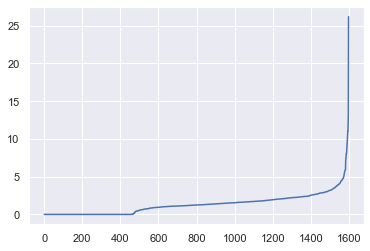

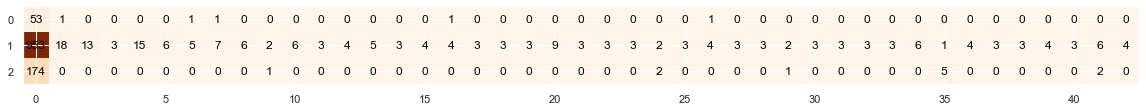

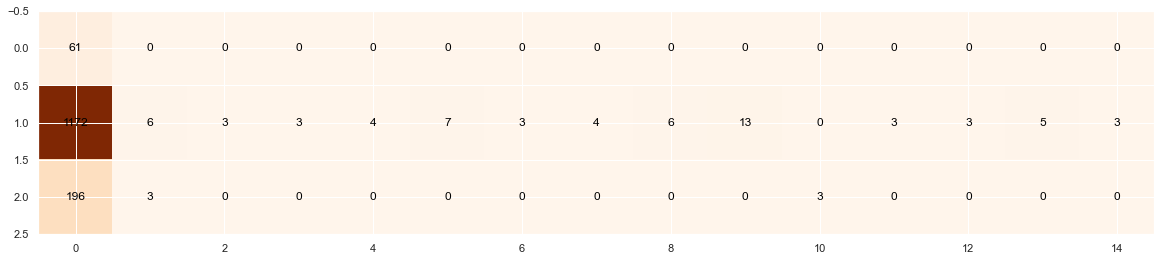

In [137]:
dbscanOptimalEps(rX)
dbscan(redDF, rX, "wine classification", 3, 3)
dbscan(redDF, rX, "wine classification", 4, 3)

### DBScan of White Wine Dataset

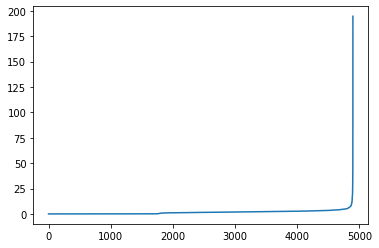

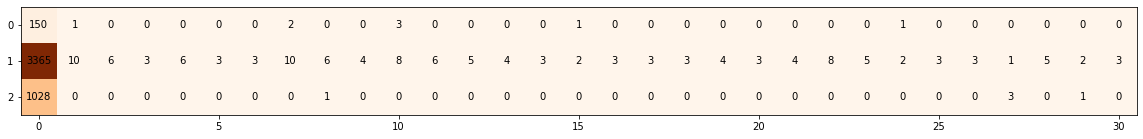

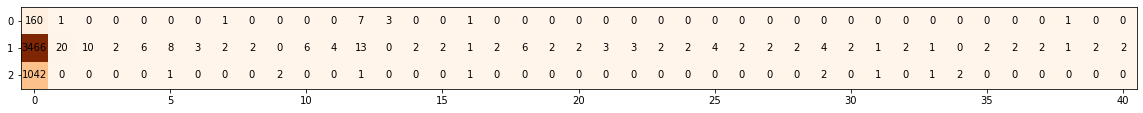

In [53]:
dbscanOptimalEps(wX)
dbscan(whiteDF, wX, "wine classification", 5, 3)
dbscan(whiteDF, wX, "wine classification", 6, 2)

### Agglomerative Hierarchical Clustering Algorithm

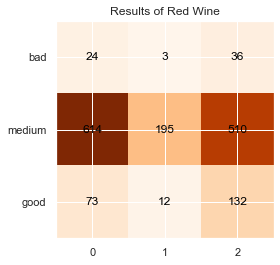

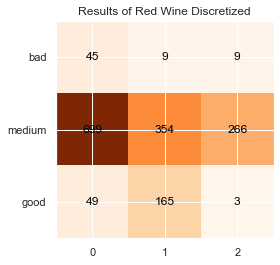

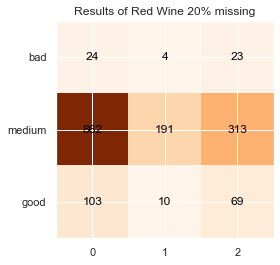

In [209]:
agglomerativeClustering(redDF, rX, "wine classification", "Results of Red Wine")
agglomerativeClustering(redDiscretDF, redDiscretX, "wine classification", "Results of Red Wine Discretized")
agglomerativeClustering(red20DF, r20X, "wine classification", "Results of Red Wine 20% missing")

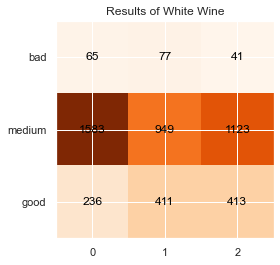

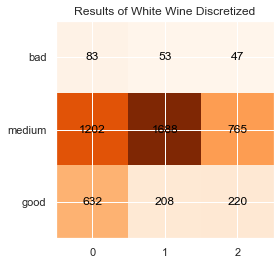

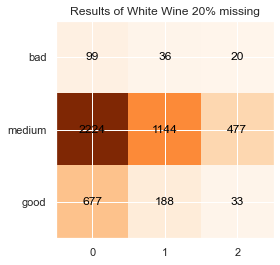

In [210]:
agglomerativeClustering(whiteDF, wX, "wine classification", "Results of White Wine")
agglomerativeClustering(whiteDiscretDF, whiteDiscretX, "wine classification", "Results of White Wine Discretized")
agglomerativeClustering(white20DF, w20X, "wine classification", "Results of White Wine 20% missing")